<a href="https://colab.research.google.com/github/TonyaAlekhina/Big-Data-Analysis/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%81%D0%BF%D0%BE%D1%80%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize,Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18,vgg16
from torch import nn
from torch.nn import Linear, Conv2d, MaxPool2d, ReLU, Dropout
from torch.optim import Adam
import torch
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data=ImageFolder("/content/drive/My Drive/kaggle/archive/train",transform=Compose([ToTensor(),Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))
test_data=ImageFolder("/content/drive/My Drive/kaggle/archive/test",transform=Compose([ToTensor(),Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))
valid_data=ImageFolder("/content/drive/My Drive/kaggle/archive/valid",transform=Compose([ToTensor(),Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))

Как выглядит один пример данных

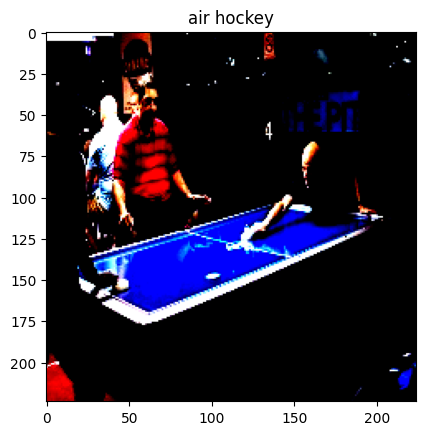

In [ ]:
for i,j in valid_data:
    plt.title(valid_data.classes[j])
    plt.imshow(i.permute(1,2,0))
    break

Загружаем наши данные по очередно

In [ ]:
train_loader=DataLoader(train_data,batch_size=16,shuffle=True)
test_loader=DataLoader(test_data,batch_size=16,shuffle=True)
val_loader=DataLoader(valid_data,batch_size=16)

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = ReLU()
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.drop = Dropout(0.2)
        self.fc1 = nn.Linear(32*56*56, 1000) # 224/2/2 = 56
        self.fc2 = nn.Linear(1000, 100)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.drop(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


Первая модель - Наша созданная

In [ ]:
model_dict = torch.load("/content/drive/My Drive/kaggle/archive/model_weights_наша.pth")
model = MyCNN()
model.load_state_dict(model_dict)
clf = model.to(device_name)
opt = Adam(clf.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

Вторая модель - vgg16

In [ ]:
model_dict = torch.load("/content/drive/My Drive/kaggle/archive/model_weights_vgg16.pth")
model=vgg16(pretrained=True) #или вместо vgg16 - resnet18
model.fc=nn.Linear(512,len(train_data.classes))
model.load_state_dict(model_dict)
clf = model.to(device_name)
opt = Adam(clf.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 72.3MB/s]


Третья модель - resnet18

In [ ]:
model_dict = torch.load("/content/drive/My Drive/kaggle/archive/model_weights_resnet18.pth")
model=resnet18(pretrained=True)
model.fc=nn.Linear(512,len(train_data.classes))
model.load_state_dict(model_dict)
clf = model.to(device_name)
opt = Adam(clf.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.2MB/s]


Пример того, как модель должна обучаться

In [ ]:
for e in range(10):
    clf.train()
    loss_total=[]
    step = 0
    for X,y in train_loader:
        step += 1
        X,y=X.to(device_name),y.to(device_name)
        yhat=clf(X)
        loss=loss_fn(yhat,y)
        loss_total.append(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()
        print(f"{step}/ {len(train_loader)}")

    print(f"Epoch {e} loss {sum(loss_total)/len(loss_total)}")
    torch.save(model.state_dict(), 'model_weights.pth')
    step = 0
    clf.eval()
    val_loss=[]
    with torch.no_grad():
        for X,y in val_loader:
            step += 1
            X,y=X.to(device_name),y.to(device_name)
            yhat=clf(X)
            loss=loss_fn(yhat,y)
            val_loss.append(loss)
            print(f"{step}/ {len(val_loader)}")

        print(f"val loss {sum(val_loss)/len(val_loss)}")

Предсказание результатов

In [ ]:
ypreds=[]
yy=[]
clf.eval()
step = 0
with torch.no_grad():
    for X,y in test_loader:
        step += 1
        X,y=X.to(device_name),y.to(device_name)
        yhat=clf(X)
        pred=torch.argmax(yhat,1)
        ypreds.extend(pred.cpu())
        yy.extend(y.cpu())
        print(f"{step}/ {len(test_loader)}")

1/ 14
2/ 14
3/ 14
4/ 14
5/ 14
6/ 14
7/ 14
8/ 14
9/ 14
10/ 14
11/ 14
12/ 14
13/ 14
14/ 14


In [ ]:
print(classification_report(ypreds,yy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.00      0.00      0.00         0
           8       1.00      0.67      0.80         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.50      1.00      0.67         1
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       0.50    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


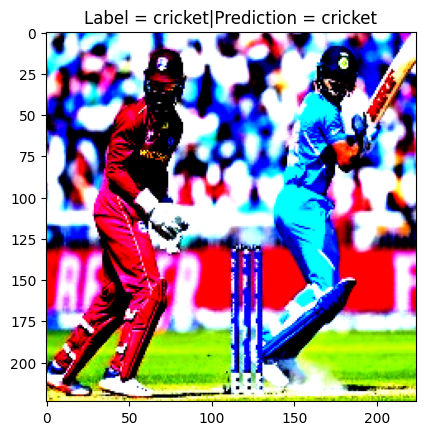

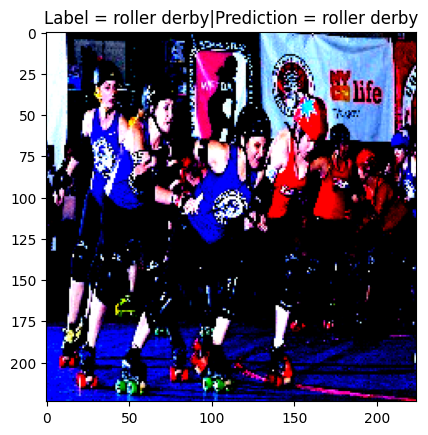

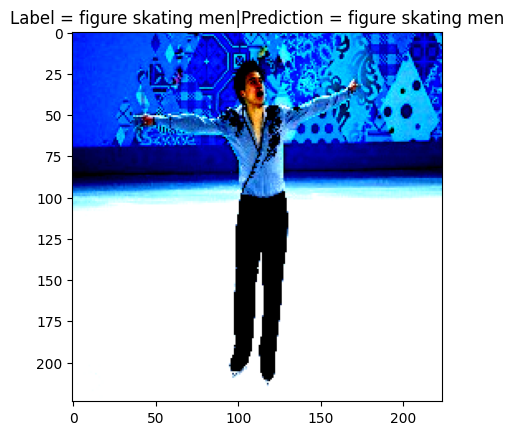

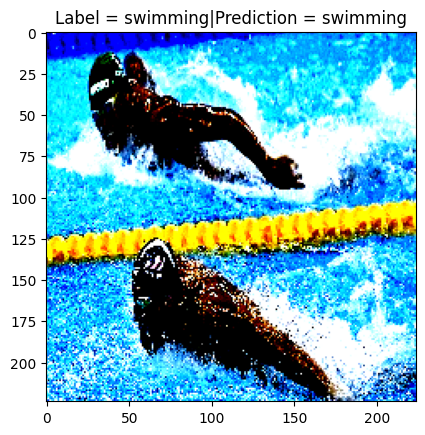

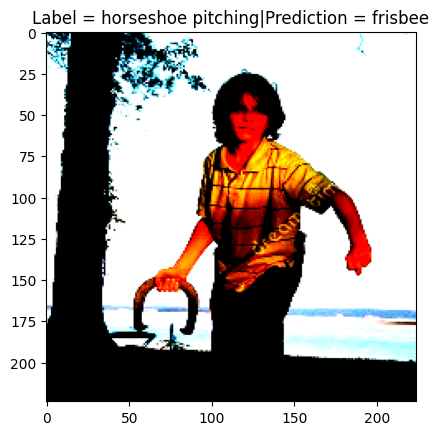

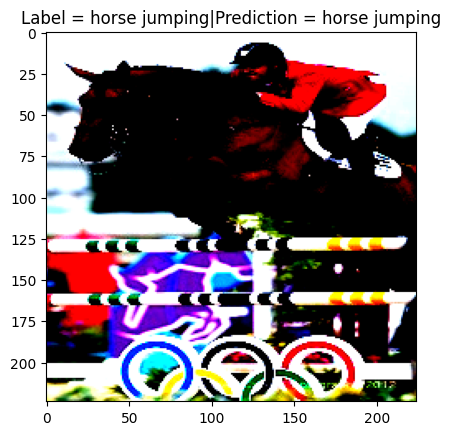

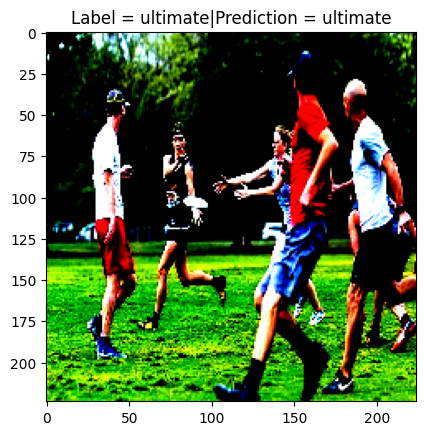

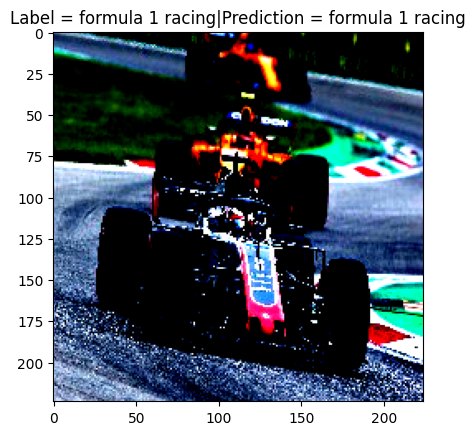

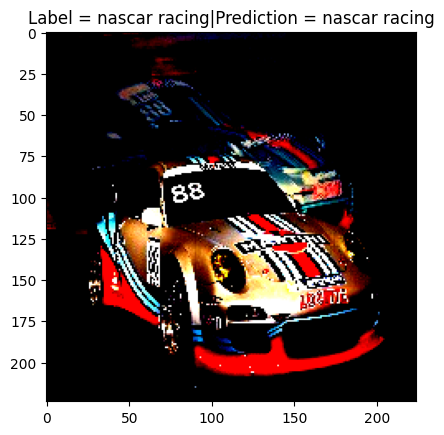

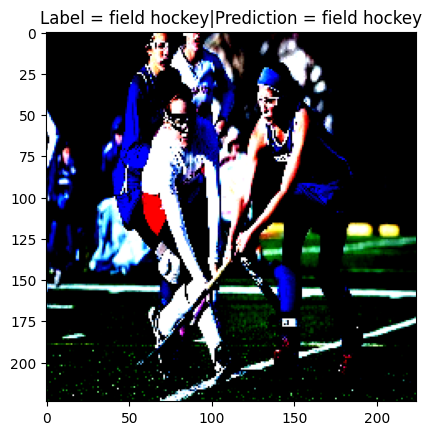

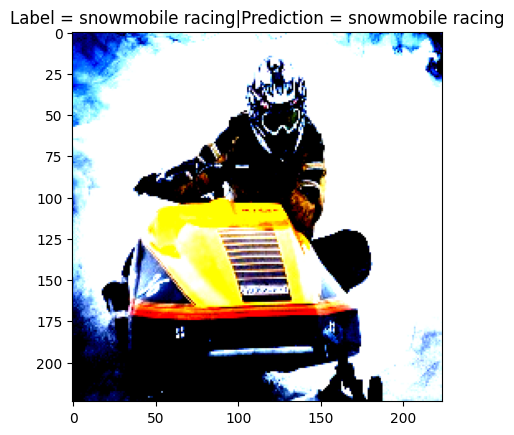

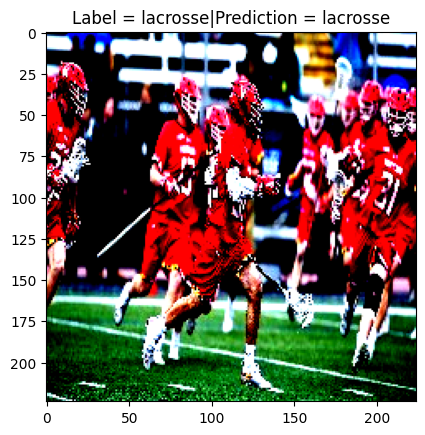

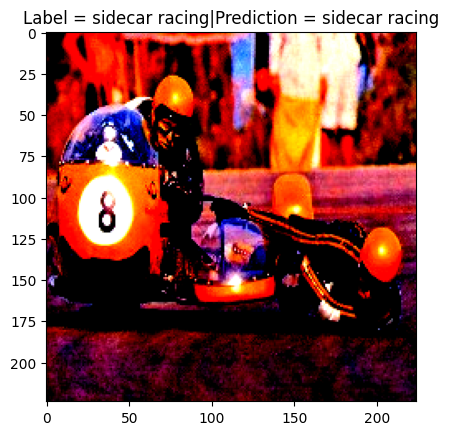

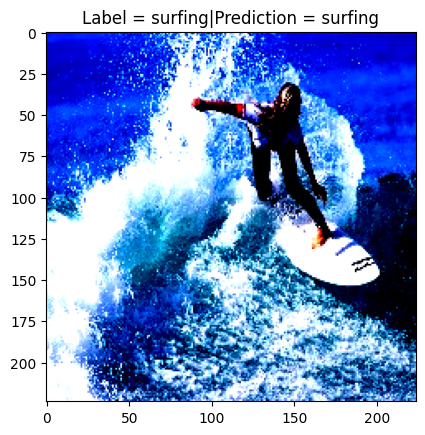

In [ ]:
clf.eval()
with torch.no_grad():
    for X,y in test_loader:
        X,y=X.to(device_name),y.to(device_name)
        yhat=clf(X[0].unsqueeze(0))
        pred=torch.argmax(yhat,1)

        plt.title("Label = "+train_data.classes[y[0]]+"|Prediction = "+train_data.classes[pred])
        plt.imshow(X[0].cpu().permute(1,2,0))
        plt.show()

In [ ]:
import os
class_names=sorted(os.listdir('/content/drive/My Drive/kaggle/archive/train'))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N))
normal_mapping

{'air hockey': 0,
 'ampute football': 1,
 'archery': 2,
 'arm wrestling': 3,
 'axe throwing': 4,
 'balance beam': 5,
 'barell racing': 6,
 'baseball': 7,
 'basketball': 8,
 'baton twirling': 9,
 'bike polo': 10,
 'billiards': 11,
 'bmx': 12,
 'bobsled': 13,
 'bowling': 14,
 'boxing': 15,
 'bull riding': 16,
 'bungee jumping': 17,
 'canoe slamon': 18,
 'cheerleading': 19,
 'chuckwagon racing': 20,
 'cricket': 21,
 'croquet': 22,
 'curling': 23,
 'disc golf': 24,
 'fencing': 25,
 'field hockey': 26,
 'figure skating men': 27,
 'figure skating pairs': 28,
 'figure skating women': 29,
 'fly fishing': 30,
 'football': 31,
 'formula 1 racing': 32,
 'frisbee': 33,
 'gaga': 34,
 'giant slalom': 35,
 'golf': 36,
 'hammer throw': 37,
 'hang gliding': 38,
 'harness racing': 39,
 'high jump': 40,
 'hockey': 41,
 'horse jumping': 42,
 'horse racing': 43,
 'horseshoe pitching': 44,
 'hurdles': 45,
 'hydroplane racing': 46,
 'ice climbing': 47,
 'ice yachting': 48,
 'jai alai': 49,
 'javelin': 50,
 '

torch.Size([3, 2474, 3760])


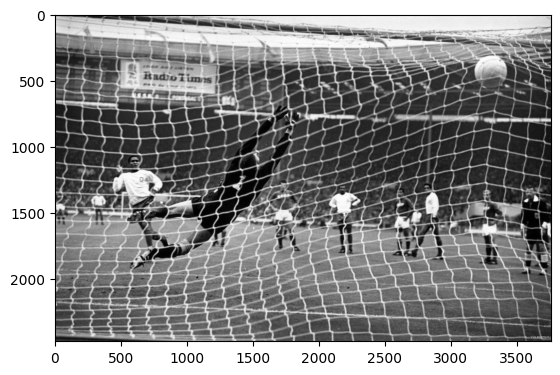

In [ ]:
import torchvision

tsr_img = torchvision.io.read_image('2.jpeg')
print(tsr_img.shape)
import matplotlib.pyplot as plt

plt.imshow(tsr_img.permute((1,2,0)))

Сперва надо узнать размеры фотографии

In [ ]:
import cv2
img = cv2.imread('1.png')
print(img.shape)
scale_factor_x = 224 / 1200
scale_factor_y = 224 / 967
img = cv2.resize(img, (0, 0), fx=scale_factor_x, fy=scale_factor_y)
img.shape

(967, 1200, 3)


(224, 224, 3)

In [ ]:
from torchvision import transforms
import torch
import torch.nn.functional as F
import cv2

# Сначала загрузите изображение с помощью OpenCV
image = cv2.imread('2.jpeg')
# Преобразуйте изображение из BGR в RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Преобразуйте изображение в тензор
image = torch.from_numpy(image)

# Преобразование размера изображения
image_resized = F.interpolate(image.permute(2, 0, 1).unsqueeze(0).float(), size=224, mode='bilinear', align_corners=False)
print(image_resized.shape)
# Нормализация изображения
normalize = transforms.Compose([
    transforms.Normalize(mean=[485, 456, 406], std=[229, 224, 225])
])

#[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]

image_normalized = normalize(image_resized.squeeze())

print(image_normalized.shape)  # Распечатает размер тензора после изменения размера и нормализации

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
image_normalized

tensor([[[-1.8375, -1.9644, -2.0106,  ..., -1.1274, -1.1847, -1.1534],
         [-1.3924, -1.3492, -1.4985,  ..., -1.1594, -1.1647, -1.1325],
         [-1.2284, -1.2149, -1.2358,  ..., -1.2713, -1.2862, -1.2278],
         ...,
         [-2.0057, -1.9697, -2.0083,  ..., -1.9495, -1.9890, -1.9486],
         [-1.9916, -2.0150, -2.0223,  ..., -1.6870, -1.6827, -1.6216],
         [-1.8711, -1.9010, -1.8688,  ..., -1.9208, -1.9053, -1.8516]],

        [[-1.7490, -1.8788, -1.9260,  ..., -1.0231, -1.0816, -1.0497],
         [-1.2940, -1.2499, -1.4025,  ..., -1.0558, -1.0612, -1.0284],
         [-1.1263, -1.1125, -1.1339,  ..., -1.1702, -1.1854, -1.1257],
         ...,
         [-1.9210, -1.8842, -1.9237,  ..., -1.8636, -1.9039, -1.8626],
         [-1.9065, -1.9305, -1.9380,  ..., -1.5952, -1.5908, -1.5283],
         [-1.7834, -1.8140, -1.7811,  ..., -1.8342, -1.8184, -1.7635]],

        [[-1.5190, -1.6482, -1.6952,  ..., -0.7963, -0.8546, -0.8228],
         [-1.0661, -1.0221, -1.1740,  ..., -0

In [ ]:
image_tensor = image_normalized.unsqueeze(0)
image_tensor.shape # добавление измерения пакета, размер станет [1, 3, 224, 224]

torch.Size([1, 3, 224, 224])

In [ ]:
clf.eval()
with torch.no_grad():
    image_tensor= image_tensor.to(device_name)
    print(image_tensor.shape)
    yhat=clf(image_tensor)
    pred=torch.argmax(yhat,1)
print(pred)

torch.Size([1, 3, 224, 224])
tensor([37], device='cuda:0')
